In [4]:
"""
    This script is based on Comprehensive Data Exploration with Python.
    Interestingly theres an author who achieved top 4% using this EDA and 
    how he does feature engineering. Just to give an idea, he uses stack regression
    of advance regression models, which is actually the competition's title is
    all about. He uses models like ridge, lasso, elastic-net models. 
"""

"\n    This script is based on Comprehensive Data Exploration with Python.\n    Interestingly theres an author who achieved top 4% using this EDA and \n    how he does feature engineering. Just to give an idea, he uses stack regression\n    of advance regression models, which is actually the competition's title is\n    all about. He uses models like ridge, lasso, elastic-net models. \n"

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #some stats

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

train = pd.read_csv('D:/Projects/MDC/HousePrice/train.csv')
test = pd.read_csv('D:/Projects/MDC/HousePrice/test.csv')

In [6]:
print(train.shape,test.shape)

(1460, 81) (1459, 80)


In [7]:
"""
Just by looking at Sales Price, you can see theres a huge deficit from 
max to 75th percentile compared to 25th percentile to min. So we might not 
be dealing with a normal dist. here. There is some heavy bias on the right.
"""
train['SalePrice'].describe()


count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

In [8]:
#Save the ids it will not help prediction 
train_id = train['Id']
test_id = test['Id']


# inplace deletes from the original train,test data 
train.drop("Id", axis = 1, inplace = True)

test.drop("Id", axis = 1, inplace = True)

In [9]:
# Distinguishing numericals and categoricals 
# Important to know that some of these 
train_num = train.select_dtypes(include=[np.number])
train_categ = train.select_dtypes(include=[np.object])
numericals = train_num.columns.values

In [10]:
train_categ.columns.values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

In [12]:
# Checking out unique variables 
discrete = []
for var in numericals:
    if len(train[var].unique())<20:
        print(var, ' values: ', train[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are 15 discrete variables


In [171]:
# Checking out missing data ratio for numerical values 
train_na_num = (train_num.isnull().sum()/len(train_num))
train_na_num = train_na_num.drop(train_na_num[train_na_num == 0].index).sort_values(ascending=False)


In [172]:
#this is just to know, when finding correlations up next, how missing values could affect stuff
#this is fine, which not much missing
train_na_num

LotFrontage   0.177
GarageYrBlt   0.055
MasVnrArea    0.005
dtype: float64

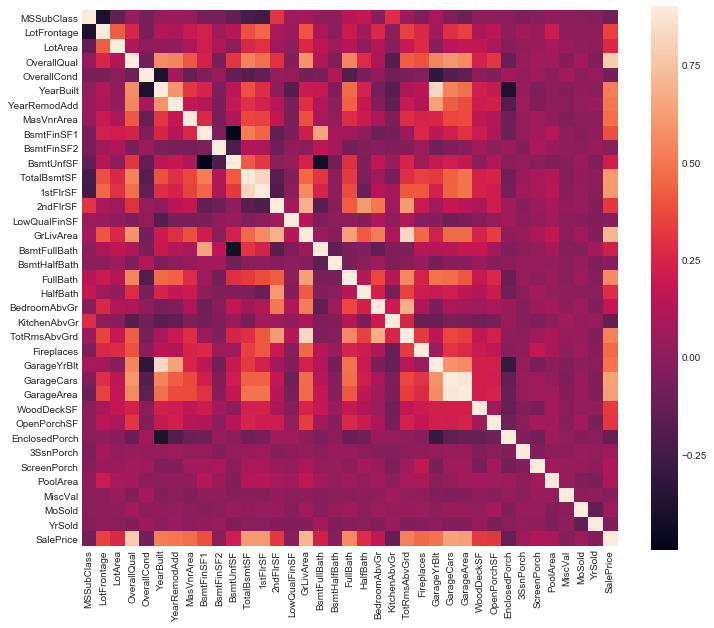

In [173]:
#corr() automatically selects only number variables to compute correlation 
# here i only used train_num at first but found out later u can use train rightaway
corrmat = train_num.corr()#the function returns a correlation dataframe matrix 
plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, vmax=0.9, square=True)

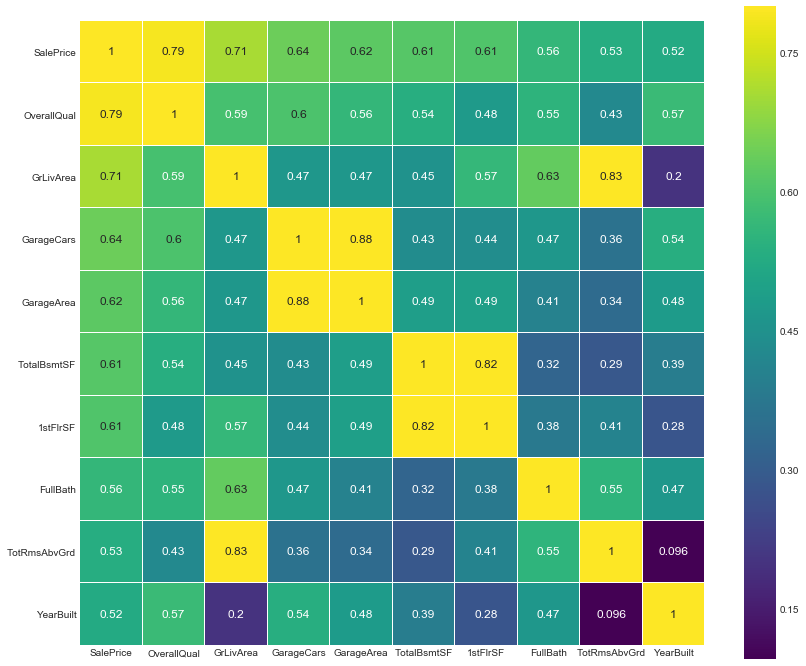

In [174]:
# Extracting top k correlations 
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
# adding a .T at the end means that its transposing (1460,10) -> (10,1460)
# this explains alot in how the function np.coorcoef accepts what kind of matrix
# next time becareful whether or not to transpose before or not
# in this case, seems like it wants one row = one feature and the columns are observations 
cm = np.corrcoef(train_num[cols].values.T)
plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

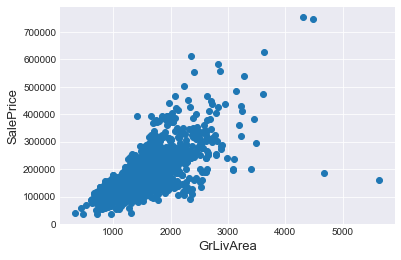

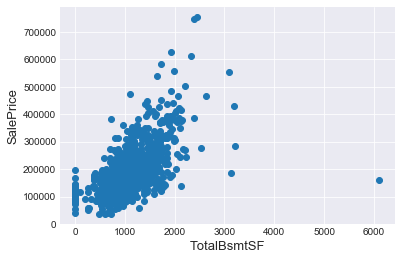

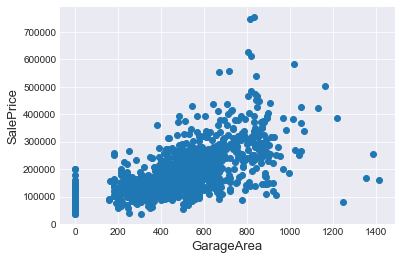

In [175]:
# Getting rid of outliers (safely) based on high correlated values
# Dropping outliers is not safe and should be considered feature by feature because it can cause overfitting of data
# FOr these features though, the outliers are very extreme. 

# GrLivArea - above ground area 
# THe two extreme outliers on the south right will not be much of a significance 
# upon deleting it. Only two values will not make any significant interpretation. 
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# TotalBsmtSF - total basement area - 1 extreme outlier
fig, ax = plt.subplots()
ax.scatter(x = train['TotalBsmtSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

# GarageArea - this may be a bit greedy, but i consider the 1200ish area point and Saleprice around 90kish to be an outlier
fig, ax = plt.subplots()
ax.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()

# Dropping them
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index)
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<100000)].index)

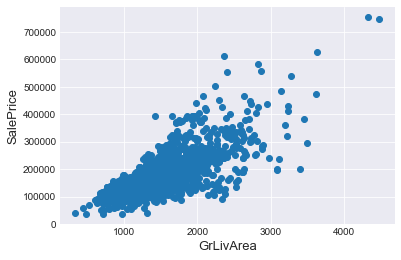

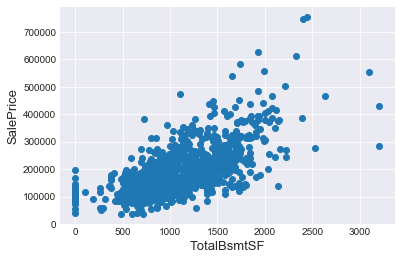

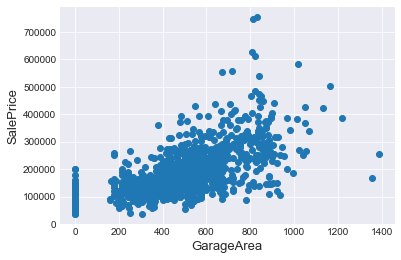

In [176]:
# Confirming our new data 
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


fig, ax = plt.subplots()
ax.scatter(x = train['TotalBsmtSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()


fig, ax = plt.subplots()
ax.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()


 mu = 181001.51 and sigma = 79451.90



D:\Conda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'SalePrice distribution')

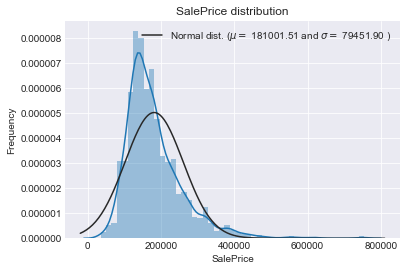

In [177]:
"""
    Target Variable- SalesPrice
    Let's explore its distribution 
    
"""


sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
# loc for location on the figure
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')




 mu = 12.02 and sigma = 0.40



D:\Conda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


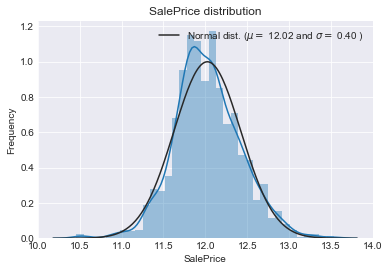

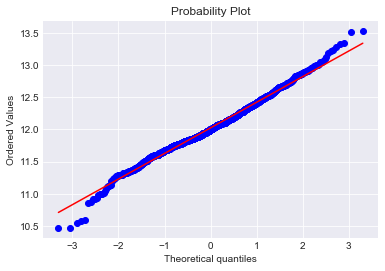

In [178]:
"""
    The distribution shows that it is right skewed. We will transform the data by
    using applying the log(1+x) transformation 
"""

train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [183]:
"""
    Let's deal with multivariate variables. 
    Feature Engineering
"""

# Exploring missing value, this is the part where is quite the same process for other kernels
ntrain = train.shape[0]
ntest = train.shape[0]
y_train = train.SalePrice.values

# When dealing with missing values, concat the data tgt and then impute
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop('SalePrice',axis = 1,inplace = True)

all_data_na = (all_data.isnull().sum() / len(all_data)) 
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)


D:\Conda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':


In [184]:
all_data_na

PoolQC         0.997
MiscFeature    0.964
Alley          0.932
Fence          0.804
FireplaceQu    0.487
LotFrontage    0.167
GarageQual     0.055
GarageCond     0.055
GarageFinish   0.055
GarageYrBlt    0.055
GarageType     0.054
BsmtExposure   0.028
BsmtCond       0.028
BsmtQual       0.028
BsmtFinType2   0.027
BsmtFinType1   0.027
MasVnrType     0.008
MasVnrArea     0.008
MSZoning       0.001
BsmtFullBath   0.001
BsmtHalfBath   0.001
Utilities      0.001
Functional     0.001
Electrical     0.000
BsmtUnfSF      0.000
Exterior1st    0.000
Exterior2nd    0.000
TotalBsmtSF    0.000
GarageArea     0.000
GarageCars     0.000
BsmtFinSF2     0.000
BsmtFinSF1     0.000
KitchenQual    0.000
SaleType       0.000
dtype: float64

In [ ]:
#When imputing missing values, it should be dealt with feature by feature case
# Lets start from the highest ratio down the line  


#'NA' means no pool 
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
#'NA' means no misc feature
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")


# no alley
all_data["Alley"] = all_data["Alley"].fillna("None")


# no fence
all_data["Fence"] = all_data["Fence"].fillna("None")

# no fire place
ll_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# fill out median by that lotFrontage from that neighborhood 
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# no garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# fill out zero for numerical values of Garage 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# numerical: fill out zero cuz no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

# categorical: fill out with none
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')


# no masonry veneer
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)


# Here 'RL' is the most common mszoning, which is fine missing data here is very few
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# can drop utilities since all data is 'ALLpub' with only one 'NoSeWa' in training data
# so we can drop it since it does not help with predictive modelling
# this is interesting because it 
all_data = all_data.drop(['Utilities'], axis=1)

# Assumes typical as the data says
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# And so the rest of the imputing is on the same process
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])



all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])



all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [208]:
# Adding a feature - total sqfoot feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [207]:
"""Encoding some features"""
# Preparing some features for labelEncoder
# Type casting them to string for numerical variables that are actually categorical
# Question here is that why OverallQuality is not categorical, i assume that its because
# OverallQuality is heavily correlated with Sale price
# Anything numerical that is not that correlated can be considered categorical provided that
# the numerical feature has some categorical feature, not like the SquareFeet features
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [209]:
# Using LabelEncoder
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2916, 80)


In [210]:
# Checking out skewed features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.946
PoolArea,17.686
LotArea,13.115
LowQualFinSF,12.082
3SsnPorch,11.370
LandSlope,4.972
KitchenAbvGr,4.300
BsmtFinSF2,4.143
EnclosedPorch,4.002
ScreenPorch,3.944


In [222]:
# Applying Box Cox Transformation instead of log1p
skewness = skewness[abs(skewness.Skew)>0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [224]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,11.693,11.686,0.000,1.194,3,1Fam,1.541,1.541,11.170,0.000,...,0.000,0.730,8,856.000,AllPub,0.000,2003,2003,2,14.977
1,12.792,0.000,0.000,1.194,3,1Fam,1.541,0.730,12.063,0.000,...,0.000,0.730,6,1262.000,AllPub,9.010,1976,1976,1,14.923
2,11.892,11.725,0.000,1.194,3,1Fam,1.541,1.194,10.200,0.000,...,0.000,0.730,6,920.000,AllPub,0.000,2001,2002,2,15.150
3,12.014,11.354,0.000,1.194,3,1Fam,0.730,1.541,8.274,0.000,...,0.000,0.730,7,756.000,AllPub,0.000,1915,1970,0,14.857
4,12.511,12.271,0.000,1.194,4,1Fam,1.541,0.000,10.971,0.000,...,0.000,0.730,9,1145.000,AllPub,8.014,2000,2000,2,15.852


In [230]:
r_all = pd.get_dummies(all_data)

In [232]:
all_data.columns.values

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces',
       'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea',
       'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive',
       'PoolArea', 'P

In [231]:
r_all.columns.values

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Fireplaces',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual',
       'LandSlope', 'LotArea', 'LotFrontage', 'LotShape', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC',
       'ScreenPorch', 'Street', 'TotRmsAbvGrd', 'TotalBsmtSF',
       'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'TotalSF',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'C

In [236]:
r_all['BldgType_1Fam']

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       0
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      0
18      1
19      1
20      1
21      1
22      1
23      0
24      1
25      1
26      1
27      1
28      1
29      1
       ..
2886    1
2887    1
2888    1
2889    0
2890    1
2891    0
2892    0
2893    1
2894    0
2895    1
2896    1
2897    1
2898    1
2899    1
2900    1
2901    1
2902    0
2903    0
2904    1
2905    0
2906    0
2907    0
2908    1
2909    0
2910    0
2911    0
2912    0
2913    1
2914    1
2915    1
Name: BldgType_1Fam, Length: 2916, dtype: uint8